In [9]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import KFold, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd

# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data
y = mnist.target.astype(int)

# Outer cross-validation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Inner cross-validation (used by RandomizedSearchCV)
inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)

# Define the pipeline
pipeline = Pipeline([
    ('remove_constant', VarianceThreshold(threshold=0.0)),
    ('scaler', RobustScaler()),
    ('selector', SelectKBest(score_func=f_classif)),
    ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'))
])

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'selector__k': [50],
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],
    'classifier__gamma': [0, 0.1, 0.2, 0.3]
}

outer_scores = []
all_predictions = []
all_true_labels = []

# Perform nested cross-validation
for train_index, test_index in outer_cv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # RandomizedSearchCV for hyperparameter tuning
    random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_grid, cv=inner_cv, n_iter=50, random_state=42, refit=True, scoring='f1_micro', n_jobs=-1)
    random_search.fit(X_train, y_train)

    # Evaluate the best model found by RandomizedSearchCV on the test set
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # Store results
    all_predictions.extend(y_pred)
    all_true_labels.extend(y_test)

# Convert results to numpy arrays for analysis
all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)

# Classification report
report = classification_report(all_true_labels, all_predictions)
print('\nClassification Report:')
print(report)

# Confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_predictions)
conf_matrix_df = pd.DataFrame(conf_matrix, index=range(10), columns=range(10))
print('\nConfusion Matrix:')
print(conf_matrix_df)



Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      6903
           1       0.92      0.96      0.94      7877
           2       0.88      0.85      0.86      6990
           3       0.86      0.85      0.86      7141
           4       0.81      0.75      0.78      6824
           5       0.84      0.83      0.83      6313
           6       0.91      0.93      0.92      6876
           7       0.91      0.92      0.91      7293
           8       0.89      0.89      0.89      6825
           9       0.78      0.81      0.79      6958

    accuracy                           0.88     70000
   macro avg       0.88      0.88      0.88     70000
weighted avg       0.88      0.88      0.88     70000


Confusion Matrix:
      0     1     2     3     4     5     6     7     8     9
0  6684     2    20     8     7    22   114    17    19    10
1     2  7528   197    24     4    22     5    55    28    12
2    42   35


Classification Report:
              precision    recall  f1-score       support
0              0.955540  0.968275  0.961865   6903.000000
1              0.922210  0.955694  0.938653   7877.000000
2              0.880077  0.846209  0.862811   6990.000000
3              0.859558  0.854502  0.857022   7141.000000
4              0.808067  0.754543  0.780388   6824.000000
5              0.841418  0.827024  0.834159   6313.000000
6              0.905936  0.930047  0.917833   6876.000000
7              0.909029  0.915261  0.912134   7293.000000
8              0.893119  0.893773  0.893446   6825.000000
9              0.780535  0.809141  0.794580   6958.000000
accuracy       0.877129  0.877129  0.877129      0.877129
macro avg      0.875549  0.875447  0.875289  70000.000000
weighted avg   0.876594  0.877129  0.876652  70000.000000


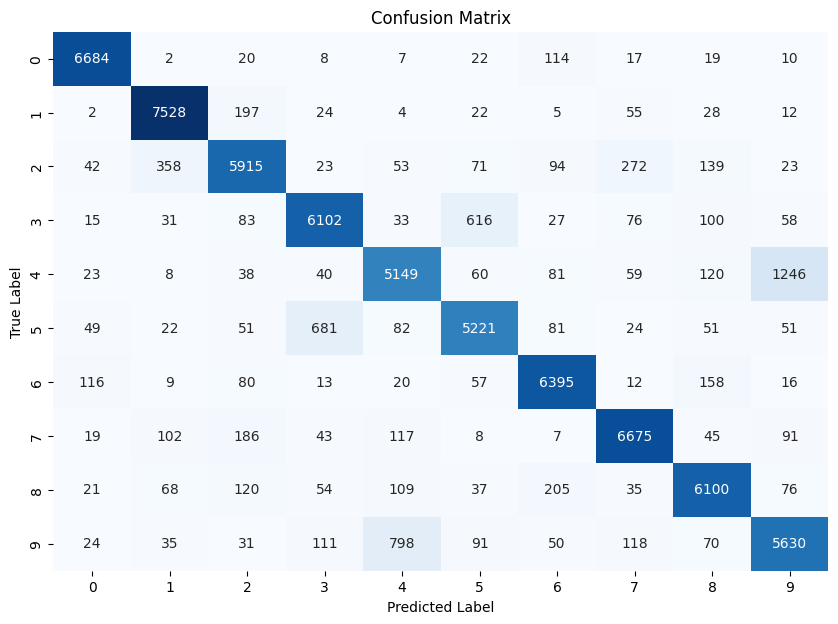

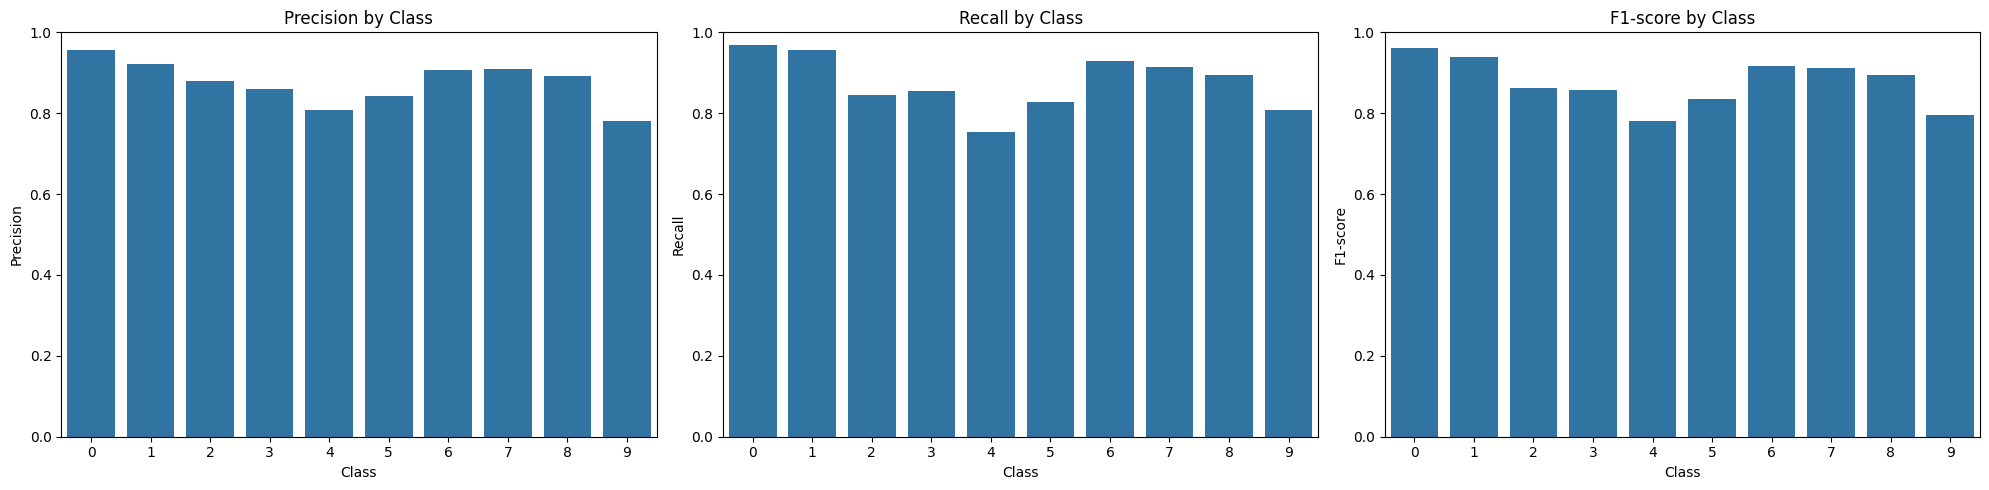

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Convert results to numpy arrays for analysis
all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)

# Classification report
report = classification_report(all_true_labels, all_predictions, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print('\nClassification Report:')
print(report_df)

# Confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_predictions)
conf_matrix_df = pd.DataFrame(conf_matrix, index=range(10), columns=range(10))

# Plot confusion matrix heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot classification metrics
metrics = ['precision', 'recall', 'f1-score']
report_df = report_df[:-3]  # Remove the last three rows: 'accuracy', 'macro avg', 'weighted avg'

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

for idx, metric in enumerate(metrics):
    sns.barplot(x=report_df.index, y=report_df[metric], ax=ax[idx])
    ax[idx].set_title(f'{metric.capitalize()} by Class')
    ax[idx].set_xlabel('Class')
    ax[idx].set_ylabel(metric.capitalize())
    ax[idx].set_ylim(0, 1)

plt.tight_layout()
plt.show()
